In [58]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [264]:
mappings = np.load("python_mappings.npy")
print(mappings.shape)
data_means = np.load("/Users/jianda/Projects/nncam_training/consts/all_means.npz")
data_stds = np.load("/Users/jianda/Projects/nncam_training/consts/all_stds.npz")
print(data_means["QL"])
print(data_stds["QL"])







(96, 144)
0.0019456508359358474
0.0038803161155459218


In [13]:
def reorder3(data):
    # Get number of variables N from input shape
    n_vars = data.shape[1] if len(data.shape) > 1 else 1
    
    # Initialize return array with shape (96*144, N)
    ret = np.empty([96*144, n_vars])
    
    # For each grid point
    for i in range(96):
        for j in range(144):
            # Calculate output index
            out_idx = i*144 + j
            # Copy all variables for this point using the mapping
            if len(data.shape) == 1:
                ret[out_idx] = data[mappings[i][j]]
            else:
                ret[out_idx,:] = data[mappings[i][j],:]
            
    return ret 

In [6]:
import sys
import os
sys.path.append(os.path.join('/Users/jianda/Projects/nncam_training/', 'models'))
from models import ResMLP

In [18]:
crash_model = ResMLP(249, 30, 512, 'relu', 7)
crash_checkpoint = torch.load('/Users/jianda/Projects/experience_replay_models/noreplay_buffer309_v3_seed1117_sample2_noprevQT_std_mix1.0/0_29_checkpoint_best_loss.pth.tar', map_location=torch.device('cpu'))
# Remove 'module.' prefix from state dict keys
crash_checkpoint['state_dict'] = {k.replace('module.', ''): v for k, v in crash_checkpoint['state_dict'].items()}

crash_model.load_state_dict(crash_checkpoint['state_dict'])


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_18440/2715037135.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  crash_checkpoint = torch.load('/Users/jianda/

<All keys matched successfully>

In [19]:
stable_model = ResMLP(249, 30, 512, 'relu', 7)
stable_checkpoint = torch.load('/Users/jianda/Projects/experience_replay_models/replay_buffer309_v3_seed1117_sample2_noprevQT_std_mix1.0/0_29_checkpoint_best_loss.pth.tar', map_location=torch.device('cpu'))
# Remove 'module.' prefix from state dict keys
stable_checkpoint['state_dict'] = {k.replace('module.', ''): v for k, v in stable_checkpoint['state_dict'].items()}

stable_model.load_state_dict(stable_checkpoint['state_dict'])


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_18440/2891335341.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stable_checkpoint = torch.load('/Users/jianda

<All keys matched successfully>

(13824, 309)
torch.Size([13824, 30])
torch.Size([13824, 30])


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_18440/3071742946.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


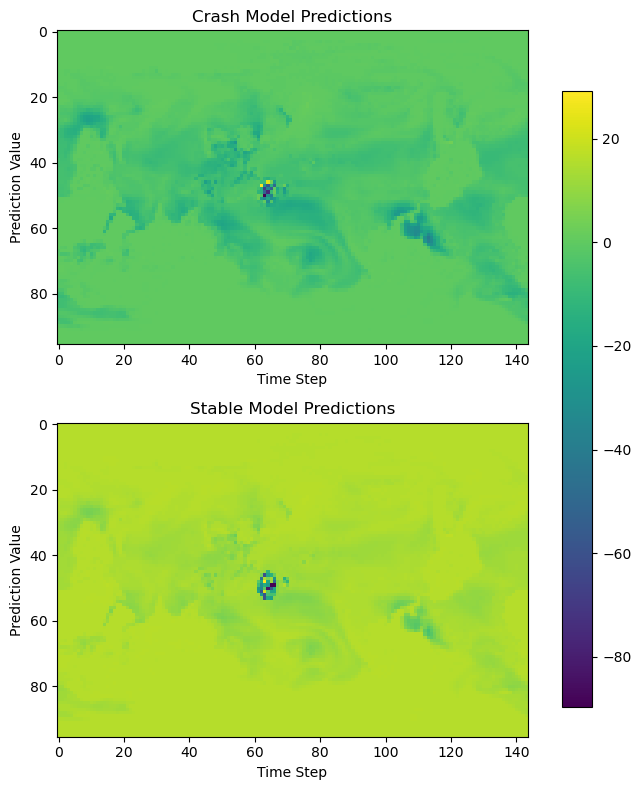

In [39]:
x_input = np.load("/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/coupled_53.npz")['x']
x_input = reorder3(x_input)
print(x_input.shape)

crash_pred = crash_model(torch.from_numpy(x_input[:,60:]).float())
print(crash_pred.shape)
stable_pred = stable_model(torch.from_numpy(x_input[:,60:]).float())
print(stable_pred.shape)
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot crash predictions
im1 = ax1.imshow(crash_pred.detach().numpy()[:,29].reshape(96,144))
ax1.set_title('Crash Model Predictions')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Prediction Value')

# Plot stable predictions 
ax2.imshow(stable_pred.detach().numpy()[:,29].reshape(96,144    ))
ax2.set_title('Stable Model Predictions')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Prediction Value')

# Add colorbar
fig.colorbar(im1, ax=(ax1, ax2))

# Adjust layout to make room for colorbar
plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.show()


(13824, 309)


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_18440/154683048.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


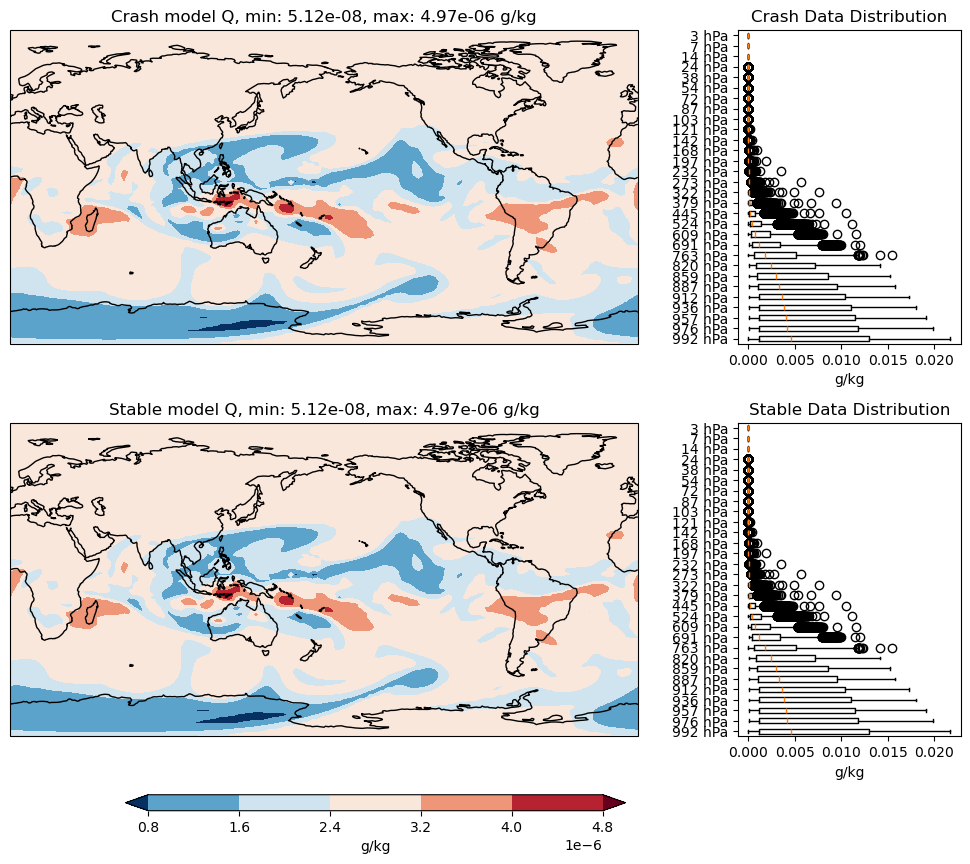

In [275]:
level = 8
step = 38
crash_input = np.load(f"/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/coupled_{step}.npz")['x']
stable_input = np.load(f"/Volumes/data_backup/experience_replay_data/online_data/noreplay_std_switch/coupled_{step}.npz")['x']
crash_input = reorder3(crash_input)[:,:30]
stable_input = reorder3(stable_input)[:,:30]

crash_input = crash_input * data_stds["QL"] + data_means["QL"]
stable_input = stable_input * data_stds["QL"] + data_means["QL"]

print(x_input.shape)

crash_data = crash_input[:,level].reshape(96,144)
stable_data = stable_input[:,level].reshape(96,144)

# Create figure with subplots using cartopy projections
fig = plt.figure(figsize=(10, 8))

# Create a gridspec to handle the layout
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])

# Create the map projections
proj = ccrs.PlateCarree(central_longitude=180)

ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax1_box = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0], projection=proj)
ax2_box = fig.add_subplot(gs[1, 1])

# Add map features
for ax in [ax1, ax2]:
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')

# Create lat/lon arrays for plotting
lats = np.linspace(-90, 90, 96)
lons = np.linspace(0, 360, 144)
lon, lat = np.meshgrid(lons, lats)

# Get min/max values across both datasets
vmin = min(crash_data.min(), stable_data.min())
vmax = max(crash_data.max(), stable_data.max())

# Plot crash predictions
im1 = ax1.contourf(lon, lat, crash_data, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax, extend='both')
ax1.set_title(f'Crash model Q, min: {crash_data.min():.2e}, max: {crash_data.max():.2e} g/kg')

# Plot stable predictions
im2 = ax2.contourf(lon, lat, stable_data, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax, extend='both')
ax2.set_title(f'Stable model Q, min: {stable_data.min():.2e}, max: {stable_data.max():.2e} g/kg')

# Define pressure levels
levs = np.array([
    3.64346569,   7.59481965,  14.35663225,  24.61222,     38.26829977,
    54.59547974,  72.01245055,  87.82123029, 103.31712663, 121.54724076,
    142.99403876, 168.22507977, 197.9080867,  232.82861896, 273.91081676,
    322.24190235, 379.10090387, 445.9925741,  524.68717471, 609.77869481,
    691.38943031, 763.40448111, 820.85836865, 859.53476653, 887.02024892,
    912.64454694, 936.19839847, 957.48547954, 976.32540739, 992.55609512]).astype(int)

# Add box plots with pressure levels
ax1_box.boxplot([crash_input[:,i].flatten() for i in range(29,-1,-1)], vert=False)
ax1_box.set_title('Crash Data Distribution')
ax1_box.set_yticks([i+1 for i in range(30)])
ax1_box.set_yticklabels([f'{levs[29-i]} hPa' for i in range(30)])
ax1_box.set_xlabel('g/kg')

ax2_box.boxplot([stable_input[:,i].flatten() for i in range(29,-1,-1)], vert=False)
ax2_box.set_title('Stable Data Distribution')
ax2_box.set_yticks([i+1 for i in range(30)])
ax2_box.set_yticklabels([f'{levs[29-i]} hPa' for i in range(30)])
ax2_box.set_xlabel('g/kg')

# Add colorbar at the bottom
cbar_ax = fig.add_axes([0.15, -0.02, 0.5, 0.02])
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('g/kg')

plt.tight_layout()
plt.show()


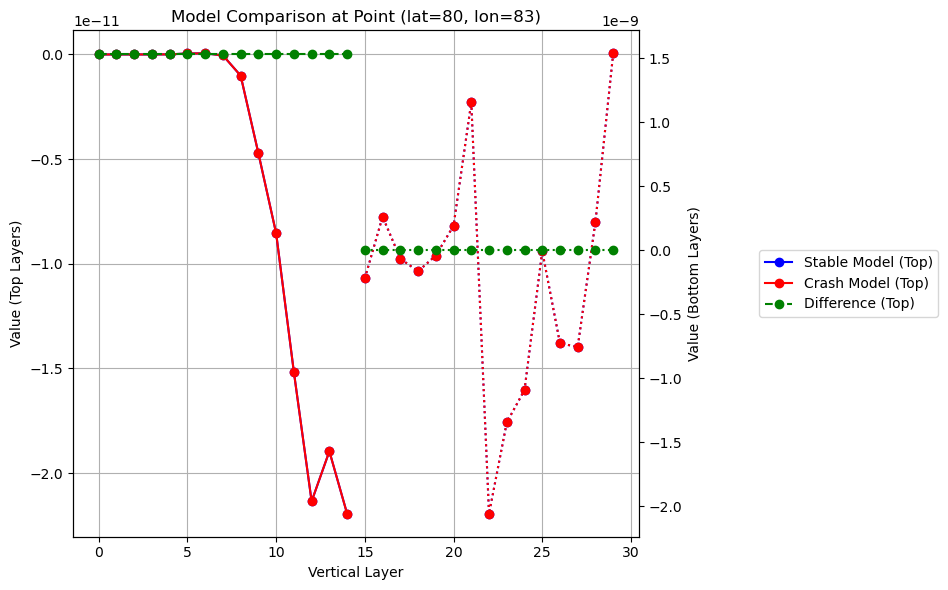

In [191]:
import matplotlib.pyplot as plt
import numpy as np

step = 37
# Load and reshape the data
crash_input = np.load(f"/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/coupled_{step}_pred.npz")['pred']
stable_input = np.load(f"/Volumes/data_backup/experience_replay_data/online_data/noreplay_std_switch/coupled_{step}_pred.npz")['pred']
crash_input = reorder3(crash_input)
stable_input = reorder3(stable_input)

# Reshape the data to 3D arrays (lat, lon, vertical_layers)
crash_model = crash_input[:,:30].reshape(96, 144, 30)
stable_model = stable_input[:,:30].reshape(96, 144, 30)

# Calculate the difference
difference = crash_model - stable_model

# Find the location of the maximum absolute difference
extreme_point = np.unravel_index(np.argmax(np.abs(difference)), difference.shape)
extreme_point = (80, 83)

# Create vertical layer indices for x-axis
vertical_layers = np.arange(30)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Split data into top and bottom layers
top_layers = slice(0, 15)
bottom_layers = slice(15, 30)

# Plot top layers on left axis
ax1.plot(vertical_layers[top_layers], stable_model[extreme_point[0], extreme_point[1], top_layers], 
         color='blue', marker='o', label='Stable Model (Top)')
ax1.plot(vertical_layers[top_layers], crash_model[extreme_point[0], extreme_point[1], top_layers], 
         color='red', marker='o', label='Crash Model (Top)')
ax1.plot(vertical_layers[top_layers], difference[extreme_point[0], extreme_point[1], top_layers], 
         color='green', linestyle='--', marker='o', label='Difference (Top)')

# Plot bottom layers on right axis
ax2.plot(vertical_layers[bottom_layers], stable_model[extreme_point[0], extreme_point[1], bottom_layers], 
         color='blue', marker='o', linestyle=':')
ax2.plot(vertical_layers[bottom_layers], crash_model[extreme_point[0], extreme_point[1], bottom_layers], 
         color='red', marker='o', linestyle=':')
ax2.plot(vertical_layers[bottom_layers], difference[extreme_point[0], extreme_point[1], bottom_layers], 
         color='green', linestyle=':', marker='o')

# Add labels and legend
ax1.set_xlabel('Vertical Layer')
ax1.set_ylabel('Value (Top Layers)')
ax2.set_ylabel('Value (Bottom Layers)')
ax1.set_title(f'Model Comparison at Point (lat={extreme_point[0]}, lon={extreme_point[1]})')
ax1.grid(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, ['Stable Model (Top)', 'Crash Model (Top)', 'Difference (Top)',
                            'Stable Model (Bottom)', 'Crash Model (Bottom)', 'Difference (Bottom)'],
           loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()

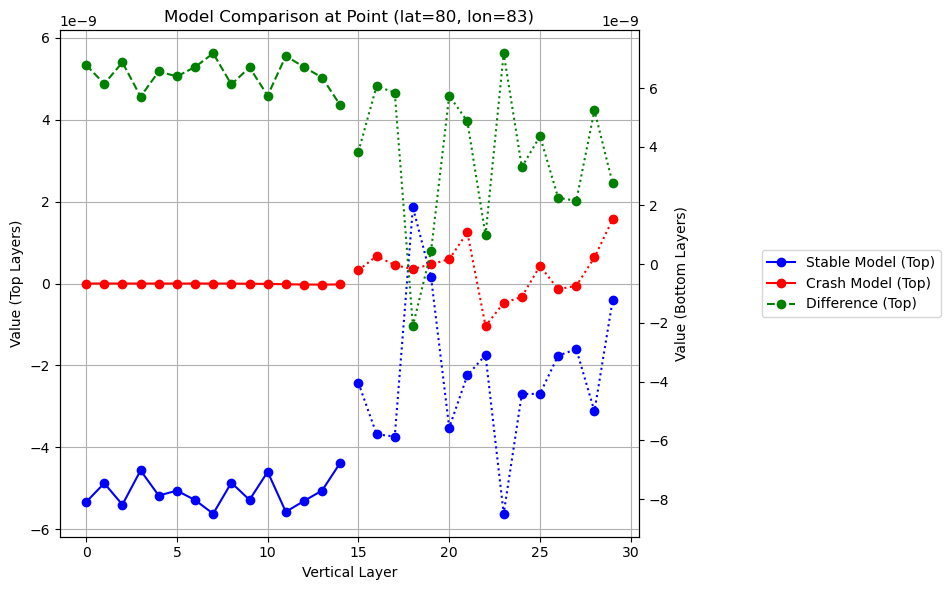

In [192]:
import matplotlib.pyplot as plt
import numpy as np

step = 38
# Load and reshape the data
crash_input = np.load(f"/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/coupled_{step}_pred.npz")['pred']
stable_input = np.load(f"/Volumes/data_backup/experience_replay_data/online_data/noreplay_std_switch/coupled_{step}_pred.npz")['pred']
crash_input = reorder3(crash_input)
stable_input = reorder3(stable_input)

# Reshape the data to 3D arrays (lat, lon, vertical_layers)
crash_model = crash_input[:,:30].reshape(96, 144, 30)
stable_model = stable_input[:,:30].reshape(96, 144, 30)

# Calculate the difference
difference = crash_model - stable_model

# Find the location of the maximum absolute difference
extreme_point = np.unravel_index(np.argmax(np.abs(difference)), difference.shape)
extreme_point = (80, 83)

# Create vertical layer indices for x-axis
vertical_layers = np.arange(30)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Split data into top and bottom layers
top_layers = slice(0, 15)
bottom_layers = slice(15, 30)

# Plot top layers on left axis
ax1.plot(vertical_layers[top_layers], stable_model[extreme_point[0], extreme_point[1], top_layers], 
         color='blue', marker='o', label='Stable Model (Top)')
ax1.plot(vertical_layers[top_layers], crash_model[extreme_point[0], extreme_point[1], top_layers], 
         color='red', marker='o', label='Crash Model (Top)')
ax1.plot(vertical_layers[top_layers], difference[extreme_point[0], extreme_point[1], top_layers], 
         color='green', linestyle='--', marker='o', label='Difference (Top)')

# Plot bottom layers on right axis
ax2.plot(vertical_layers[bottom_layers], stable_model[extreme_point[0], extreme_point[1], bottom_layers], 
         color='blue', marker='o', linestyle=':')
ax2.plot(vertical_layers[bottom_layers], crash_model[extreme_point[0], extreme_point[1], bottom_layers], 
         color='red', marker='o', linestyle=':')
ax2.plot(vertical_layers[bottom_layers], difference[extreme_point[0], extreme_point[1], bottom_layers], 
         color='green', linestyle=':', marker='o')

# Add labels and legend
ax1.set_xlabel('Vertical Layer')
ax1.set_ylabel('Value (Top Layers)')
ax2.set_ylabel('Value (Bottom Layers)')
ax1.set_title(f'Model Comparison at Point (lat={extreme_point[0]}, lon={extreme_point[1]})')
ax1.grid(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, ['Stable Model (Top)', 'Crash Model (Top)', 'Difference (Top)',
                            'Stable Model (Bottom)', 'Crash Model (Bottom)', 'Difference (Bottom)'],
           loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()